## **Method** №1 - поиск похожих картинок по входной картинке + доп текст

In [ ]:
!pip install ftfy regex tqdm
!pip install transformers
!pip install datasets

  Using cached clip_by_openai-1.1-py3-none-any.whl (1.4 MB)
  Using cached ftfy-6.1.1-py3-none-any.whl (53 kB)
  Using cached regex-2023.6.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (770 kB)
  Using cached tqdm-4.65.0-py3-none-any.whl (77 kB)
INFO: pip is looking at multiple versions of clip-by-openai to determine which version is compatible with other requirements. This could take a while.
  Using cached clip_by_openai-1.0.1-py3-none-any.whl (1.4 MB)
  Using cached clip_by_openai-0.1.1.5-py3-none-any.whl (1.4 MB)
  Using cached clip_by_openai-0.1.1.4-py3-none-any.whl (1.4 MB)
  Using cached clip_by_openai-0.1.1.3-py3-none-any.whl (1.4 MB)
  Using cached clip_by_openai-0.1.1.2-py3-none-any.whl (1.4 MB)
  Using cached clip_by_openai-0.1.1-py3-none-any.whl (13 kB)
  Using cached clip_by_openai-0.1.0-py3-none-any.whl (13 kB)
INFO: pip is looking at multiple versions of clip-by-openai to determine which version is compatible with other requirements. This could take a whil

In [ ]:
# imports
from PIL import Image
from transformers import AutoTokenizer, CLIPProcessor, CLIPModel
import torch


In [ ]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
preprocess = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")
captions = [
            "is short sleeved and has a collar",
            "is grey with shorter sleeves"
 ]
bad_captions = [
            "is red and for women",
            "is white and for women"
 ]

In [ ]:
target = 'B00CBNH8JK.png'
candidate = 'B008E5CF6U.png'
bad_images = ["B0097ZOQDG.png", "B0097ZN7IG.png", "B0097ZNH7M.png"]

MATCH
its a match


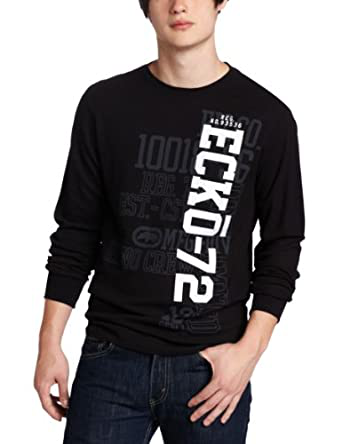

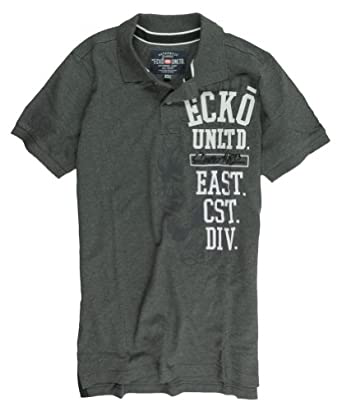

is short sleeved and has a collar
its a match


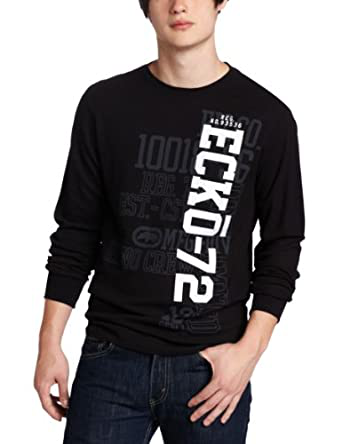

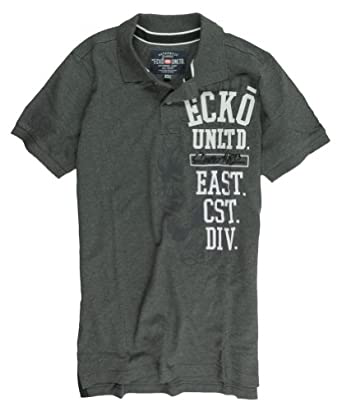

is grey with shorter sleeves
NOT MATCH
its NOT a match


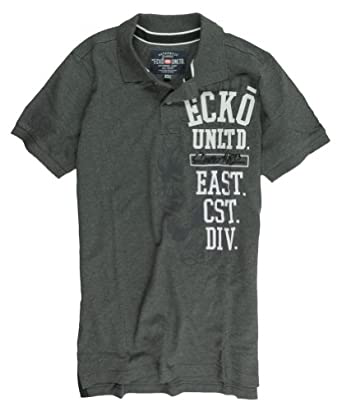

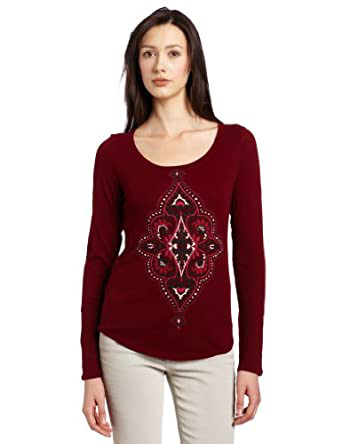

is short sleeved and has a collar
its NOT a match


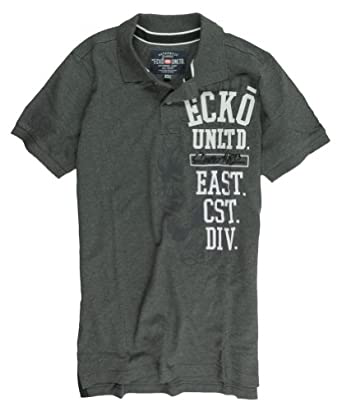

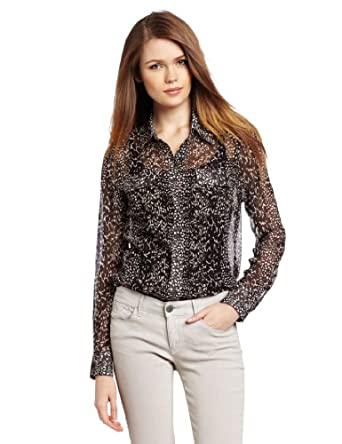

is short sleeved and has a collar
its NOT a match


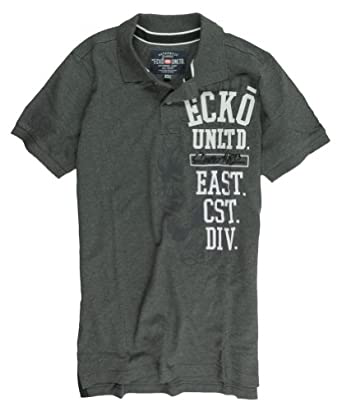

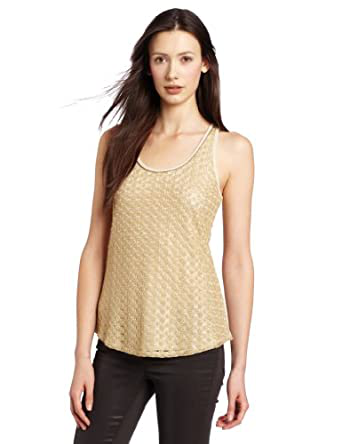

is short sleeved and has a collar
its NOT a match


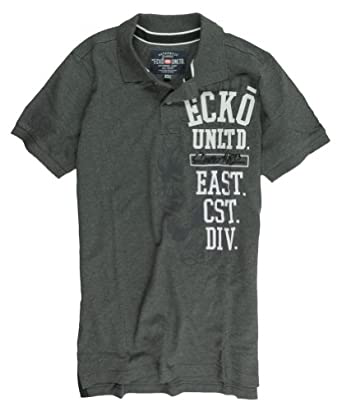

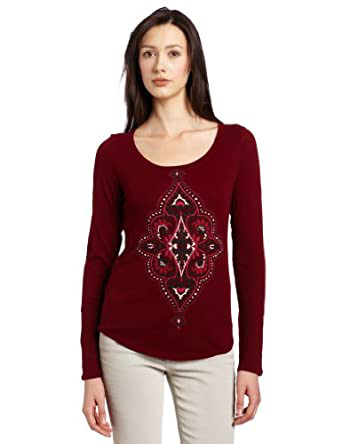

is grey with shorter sleeves
its NOT a match


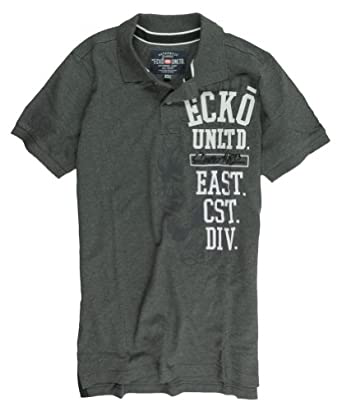

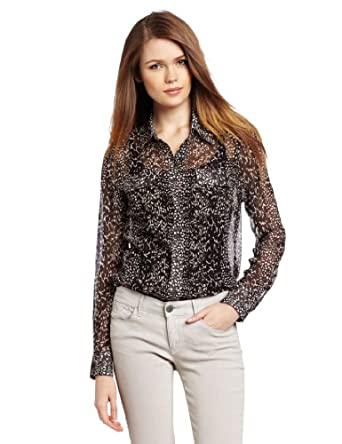

is grey with shorter sleeves
its NOT a match


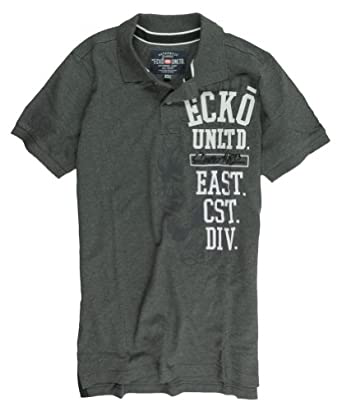

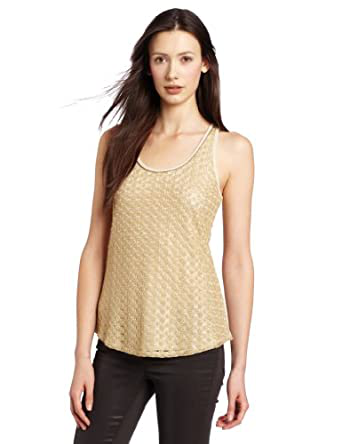

is grey with shorter sleeves
its NOT a match


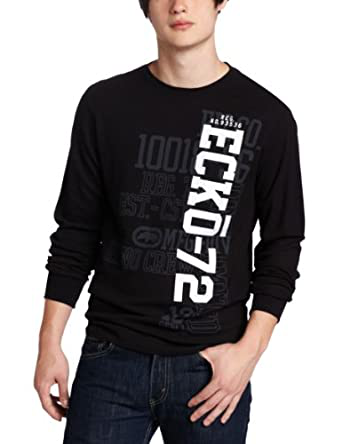

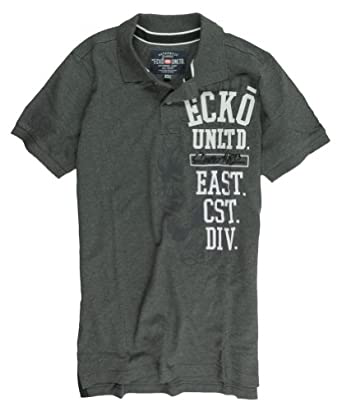

is red and for women
its NOT a match


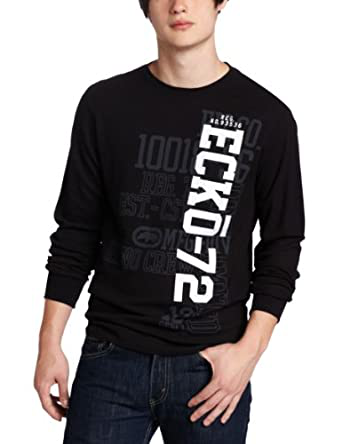

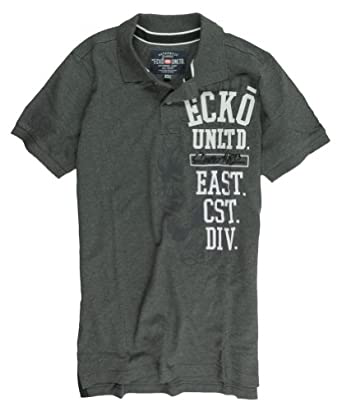

is white and for women


In [ ]:
def get_similary_between_captions_image(source_img, target_img, caption):
  with torch.no_grad():

    #input image
    # можно батчами
    image_features = model.get_image_features(**preprocess(images=Image.open(source_img), return_tensors="pt"))
    image_features /= image_features.norm(dim=-1, keepdim=True)

    #text retrival
    inputs = tokenizer(["Clothes with atribute: {}".format(caption)], padding=True, return_tensors="pt")
    text_features = model.get_text_features(**inputs)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    #focus images
    image_2_features = model.get_image_features(**preprocess(images=Image.open(target_img), return_tensors="pt"))
    image_2_features /= image_2_features.norm(dim=-1, keepdim=True)

    image_features = (image_features + text_features)

    img1 = Image.open(source_img)
    img2 = Image.open(target_img)


    if (image_2_features.cpu().numpy() @ image_features.cpu().numpy().T)[0][0] > 1:
      print('its a match')
    else:
      print('its NOT a match')

    img1.show()
    img2.show()
    print(caption)



print("MATCH")
get_similary_between_captions_image(candidate, target, captions[0])
get_similary_between_captions_image(candidate, target, captions[1])

print("NOT MATCH")
get_similary_between_captions_image(target, bad_images[0], captions[0])
get_similary_between_captions_image(target, bad_images[1], captions[0])
get_similary_between_captions_image(target, bad_images[2], captions[0])
get_similary_between_captions_image(target, bad_images[0], captions[1])
get_similary_between_captions_image(target, bad_images[1], captions[1])
get_similary_between_captions_image(target, bad_images[2], captions[1])

get_similary_between_captions_image(candidate, target, bad_captions[0])
get_similary_between_captions_image(candidate, target, bad_captions[1])


## **Method** №2 - поиск похожих картинок


In [ ]:
bad_images

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
import os

# Define the path to the pre-trained ResNet-50 model
model_path = 'resnet50.pth'
# Define the path to the dataset folder containing images to compare with
data_path = ''

# Load the pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)
# Remove the last fully-connected layer of the model
model = nn.Sequential(*list(model.children())[:-1])

# Set the model to evaluation mode
model.eval()

# Define the image transformation pipeline
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the query image
query_image_path = target
query_image = Image.open(query_image_path)
query_image_tensor = transform(query_image).unsqueeze(0)

# Compute the features of the query image using the pre-trained model
with torch.no_grad():
    query_features = model(query_image_tensor).squeeze()


image_paths = bad_images
image_paths.append(candidate)

# Compute the features of all images in the dataset folder
data_features = []
for filename in image_paths:
    image_path = os.path.join(data_path, filename)
    image = Image.open(image_path)
    image_tensor = transform(image).unsqueeze(0)
    with torch.no_grad():
        features = model(image_tensor).squeeze()
    data_features.append(features)

# Compute the cosine similarity between the query image features and the dataset image features
similarities = np.dot(query_features, torch.stack(data_features).T)
# Sort the similarities in descending order
indices = np.argsort(similarities)[::-1]

# Print the top 10 most similar images
print("Top 1 most similar images:")
for i in range(1):
    print(image_paths[indices[i]])

Top 1 most similar images:
B008E5CF6U.png


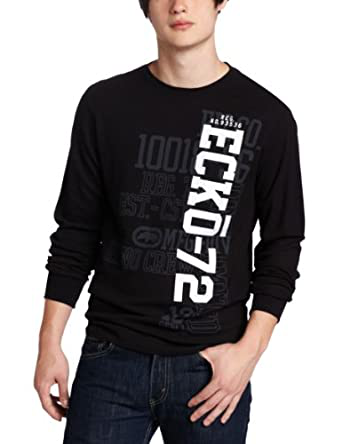

In [ ]:
# наиболее похожая найденная картинка
img1 = Image.open(image_paths[indices[i]])
img1.show()

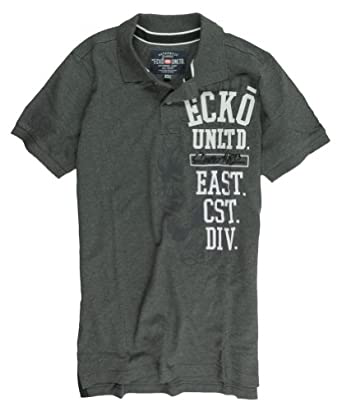

In [ ]:
# исходная картинка

img1 = Image.open(target)
img1.show()

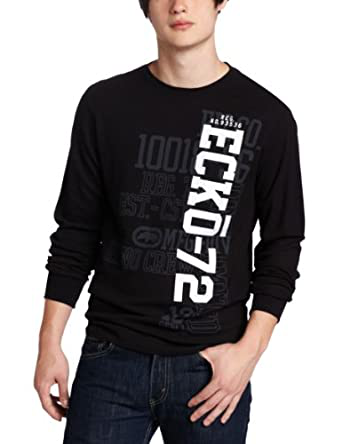

In [ ]:
# ответ
img1 = Image.open(candidate)
img1.show()

## **Method** №3 - Image captioning

https://huggingface.co/docs/transformers/model_doc/vision-encoder-decoder

In [ ]:
import requests
from PIL import Image

from transformers import GPT2TokenizerFast, ViTImageProcessor, VisionEncoderDecoderModel

# load a fine-tuned image captioning model and corresponding tokenizer and image processor
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = GPT2TokenizerFast.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
image_processor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")


a man in a black shirt and jeans 


a man in a black shirt and jeans 


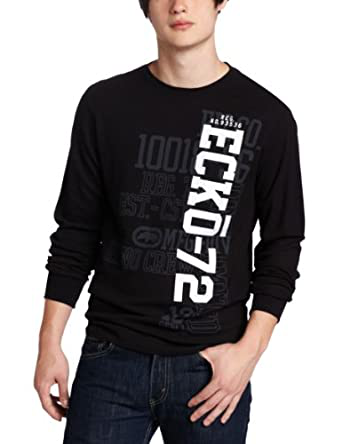

In [ ]:
# let's perform inference on an image
image = Image.open(candidate)
pixel_values = image_processor(image, return_tensors="pt").pixel_values

# autoregressively generate caption (uses greedy decoding by default)
generated_ids = model.generate(pixel_values)
generated_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_text)
image.show()

a woman standing in front of a wall with a red and white checkered shirt 


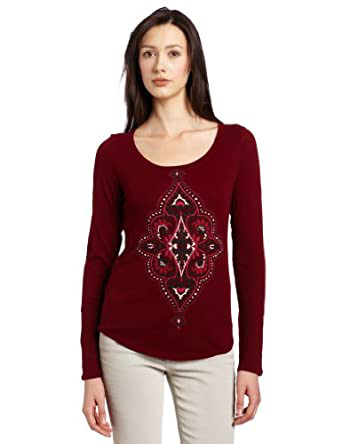

In [ ]:
# let's perform inference on an image
image = Image.open(bad_images[0])
pixel_values = image_processor(image, return_tensors="pt").pixel_values

# autoregressively generate caption (uses greedy decoding by default)
generated_ids = model.generate(pixel_values)
generated_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_text)
image.show()

In [ ]:
# поиск похож

SyntaxError: ignored


## **Method** №4 - Поиск похожего текста

In [ ]:
# Import required libraries
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModel

# Load pre-trained model and tokenizer
model_name = 'sentence-transformers/paraphrase-MiniLM-L6-v2'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Define input sentence
input_sentence = "a man in a black shirt and jeans"

# Tokenize input sentence
input_ids = tokenizer.encode(input_sentence,
                             padding='max_length',
                             truncation=True,
                             max_length=128,
                             return_tensors='pt')

# Get model output
with torch.no_grad():
    outputs = model(input_ids)

# Get sentence embedding
sentence_embedding = outputs.last_hidden_state.mean(dim=1).squeeze()

# Load data to compare with input sentence
data = ['a woman standing with a red and white checkered shirt ',
        'a man with white hat with yellow jacket',
        'a man with strict black jacket',
        'a man white shorts with black top']

# Tokenize data
data_embeddings = []
for sentence in data:
    input_ids = tokenizer.encode(sentence,
                                 padding='max_length',
                                 truncation=True,
                                 max_length=128,
                                 return_tensors='pt')
    with torch.no_grad():
        outputs = model(input_ids)
    data_embeddings.append(outputs.last_hidden_state.mean(dim=1).squeeze())

# Calculate cosine similarity between input sentence and all sentences in data
similarities = []
for embedding in data_embeddings:
    cosine_similarity = torch.nn.functional.cosine_similarity(sentence_embedding, embedding, dim=0).item()
    similarities.append(cosine_similarity)

# Get most similar sentence
most_similar_index = np.argmax(similarities)
most_similar_sentence = data[most_similar_index]

print("Input sentence:", input_sentence)
print("Most similar sentence:", most_similar_sentence)

Input sentence: a man in a black shirt and jeans
Most similar sentence: a man with strict black jacket


## Доп подход metric learning - для того, чтобы эмбединги похожих вещей были еще ближе и наоборот

https://kevinmusgrave.github.io/pytorch-metric-learning/
https://medium.com/@tkm45/the-new-pytorch-package-that-makes-metric-learning-simple-5e844d2a1142

## Extract dominant color of an image using Python



In [ ]:
from __future__ import print_function
import binascii
import struct
from PIL import Image
import numpy as np
import scipy
import scipy.misc
import scipy.cluster

NUM_CLUSTERS = 5

im = Image.open(target)
im = im.resize((150, 150))      # optional, to reduce time
ar = np.asarray(im)
shape = ar.shape
ar = ar.reshape(np.product(shape[:2]), shape[2]).astype(float)

codes, dist = scipy.cluster.vq.kmeans(ar, NUM_CLUSTERS)

vecs, dist = scipy.cluster.vq.vq(ar, codes)         # assign codes
counts, bins = np.histogram(vecs, len(codes))    # count occurrences

index_max = np.argmax(counts)                    # find most frequent
peak = codes[index_max]
colour = binascii.hexlify(bytearray(int(c) for c in peak)).decode('ascii')
print('most frequent is %s (#%s)' % (peak, colour))

most frequent is [253.56009756 253.69190244 253.61453659] (#fdfdfd)


In [ ]:
!pip install colorthief
from colorthief import ColorThief
color_thief = ColorThief(target)
# get the dominant color
dominant_color = color_thief.get_color(quality=1)
print('dominant color: ', palette)

dominant color:  [(72, 77, 73), (216, 219, 217), (137, 141, 139), (159, 163, 164), (164, 172, 166), (115, 124, 121)]


In [ ]:
palette = color_thief.get_palette(color_count=6)
print('palette: ', palette)

[(72, 77, 73), (216, 219, 217), (137, 141, 139), (159, 163, 164), (164, 172, 166), (115, 124, 121)]
